In [1]:
# TODO (optional) Change padding "same" --> "valid". It will change sizes to be smaller yet. (4x4 instead of 7x7 in those 2 places)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
import random

In [2]:
# Define the device (use GPU if available)
device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')

# Print the device type
print(f'Using device: {device}')

# If using a CUDA device, print the name of the CUDA device
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(device.index)
    print(f'Device name: {device_name}')

Using device: cuda:5
Device name: Quadro RTX 6000


In [3]:
# Transformation for the images (resize, normalization, etc.)
img_size = 32
batch_size = 512

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)), # Resizing to 28x28 pixels as in the original MNIST format
    transforms.ToTensor(),         # Convert image to tensor
    transforms.Normalize(          # Normalize with ImageNet mean and std
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

# Assuming your images are already saved in appropriate directories
# Replace the path with where your Fashion MNIST images are stored
train_dataset = datasets.ImageFolder(root="Real_VS_AI/train", transform=transform)
test_dataset = datasets.ImageFolder(root="Real_VS_AI/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(train_loader.dataset.classes)

# Display dataset information
print(f'Training set size: {len(train_loader.dataset)} samples')
print(f'Testing set size: {len(test_loader.dataset)} samples')
print(f'Number of classes: {num_classes}')

Training set size: 155015 samples
Testing set size: 30000 samples
Number of classes: 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.2391288].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7582842..1.8379141].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6127234..0.810429].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5105042..1.9383754].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.810224..2.2391288].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7925336..2.2391288].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802.

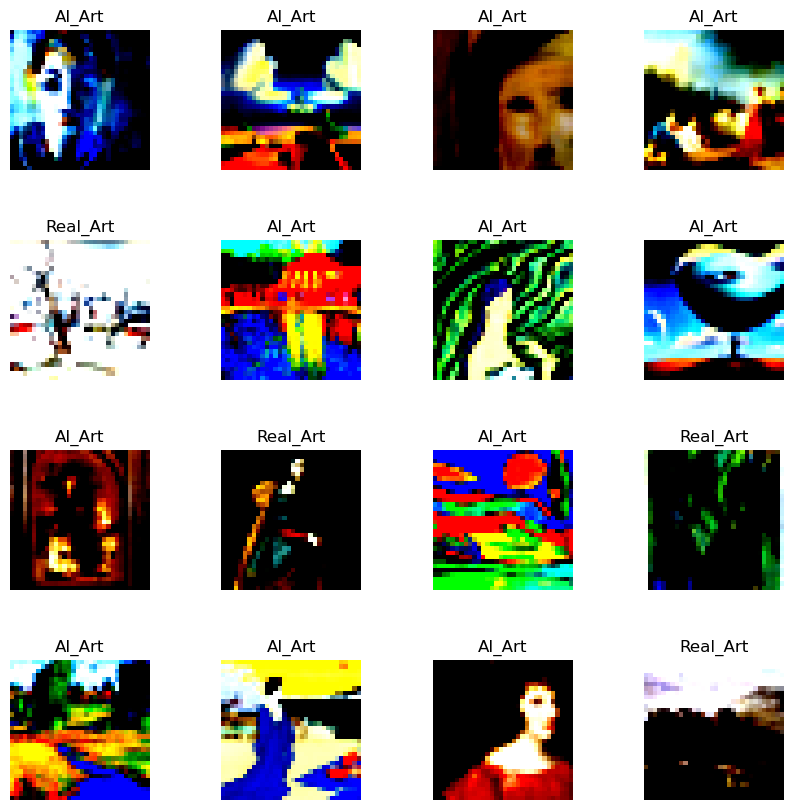

In [4]:
# Define function that plots multiple images from a DataLoader
def PlotImages(num_img, rows, cols, loader, label_names, color=True):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    images, labels = [], []
    for batch_images, batch_labels in loader:
        for i in range(len(batch_images)):
            images.append(batch_images[i])
            labels.append(batch_labels[i].item())
            if len(images) >= num_img:
                break
        if len(images) >= num_img:
            break
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        image_np = image.permute(1, 2, 0).numpy()
        plt.imshow(image_np)
        plt.title(label_names[labels[i]])

PlotImages(num_img=16, rows=4, cols=4, loader=train_loader, label_names=train_loader.dataset.classes)

In [5]:
# Define the LeNet model
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding='same')
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding='same')
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=16*int(img_size/4)*int(img_size/4), out_features=240)
        self.fc2 = nn.Linear(in_features=240, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = x.view(x.shape[0], 16*int(img_size/4)*int(img_size/4))
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x
        
model = LeNet().to(device)

print(model)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=1024, out_features=240, bias=True)
  (fc2): Linear(in_features=240, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=2, bias=True)
)


In [6]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

print('Model, loss function, and optimizer are set up.')

Model, loss function, and optimizer are set up.


In [ ]:
# Training loop
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    time_start = time()
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #TODO: Early stopping
            
            total_loss += loss.item()
            
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

    time_stop = time()
    time_elapsed = time_stop - time_start
    print(f'elapsed time {round(time_elapsed,1)} sec.')

train_model(model, train_loader, criterion, optimizer, epochs=25)

In [ ]:
# Testing loop
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

print(f'Test Accuracy of the model on the test dataset: {test_model(model, test_loader):.2f}')

| Device | Batch Size | Image Size | Accuracy | Time (sec) | Epochs | Test      |
|:-------|:-----------|:-----------|:---------|:-----------|:-------|:----------|
| GPU    | 512        | 256x256    | 0.92     | 27700      | 25     | AI vs Real|
| GPU    | 512        | 256x256    | 0.46     | 4834.9     | 5      |           |
| GPU    | 512        | 128x128    | 0.41     | 4485.4     | 5      |           |